In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import NCFDataset
from recom_ncf import NCFRecommender
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/review-clean.csv')[['user_idx', 'item_idx', 'rating_imp', 'timestamp', 'review']]
df.head()

,user_idx,item_idx,rating_imp,timestamp,review
0,0,0,1,1738278781,A legendary tactical shooter that shaped the g...
1,1,0,1,1736206418,"The best CS sure, but server browser is the il..."
2,2,0,1,1738041574,Some of the best memories of my childhood were...
3,3,0,1,1738015332,This game feels so much better than CS2. I kno...
4,4,0,1,1737853720,its very fun to play you can make friends out ...


## Splitting the data

In [3]:
df_train_eval, df_test = train_test_split(df[['user_idx', 'item_idx', 'rating_imp']], test_size=0.1, random_state=42)
df_train, df_eval = train_test_split(df_train_eval, test_size=(0.1/0.9), random_state=42)

train_dataset = NCFDataset(df_train)
eval_dataset = NCFDataset(df_eval)
test_dataset = NCFDataset(df_test)

train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=8192, shuffle=False)
test_dataloader = DataLoader(eval_dataset, batch_size=8192, shuffle=False)

unique_users = df["user_idx"].unique()
unique_items = df["item_idx"].unique()

In [4]:
print(df_train.shape)
print(df_eval.shape)
print(df_test.shape)

(1413153, 3)
(176645, 3)
(176645, 3)


## Train model

In [5]:
model = NCFRecommender(unique_users, unique_items)
model.fit(train_dataloader, eval_dataloader)

Epoch 1/20
Train loss: 0.790297, Eval loss: 0.776626
Epoch 2/20
Train loss: 0.764231, Eval loss: 0.751656
Epoch 3/20
Train loss: 0.740500, Eval loss: 0.728890
Epoch 4/20
Train loss: 0.718847, Eval loss: 0.708116
Epoch 5/20
Train loss: 0.699087, Eval loss: 0.689147
Epoch 6/20
Train loss: 0.681045, Eval loss: 0.671814
Epoch 7/20
Train loss: 0.664552, Eval loss: 0.655966
Epoch 8/20
Train loss: 0.649495, Eval loss: 0.641473
Epoch 9/20
Train loss: 0.635709, Eval loss: 0.628207
Epoch 10/20
Train loss: 0.623078, Eval loss: 0.616056
Epoch 11/20
Train loss: 0.611538, Eval loss: 0.604921
Epoch 12/20
Train loss: 0.600944, Eval loss: 0.594710
Epoch 13/20
Train loss: 0.591229, Eval loss: 0.585339
Epoch 14/20
Train loss: 0.582320, Eval loss: 0.576733
Epoch 15/20
Train loss: 0.574163, Eval loss: 0.568826
Epoch 16/20
Train loss: 0.566632, Eval loss: 0.561551
Epoch 17/20
Train loss: 0.559709, Eval loss: 0.554855
Epoch 18/20
Train loss: 0.553342, Eval loss: 0.548688
Epoch 19/20
Train loss: 0.547498, Eva

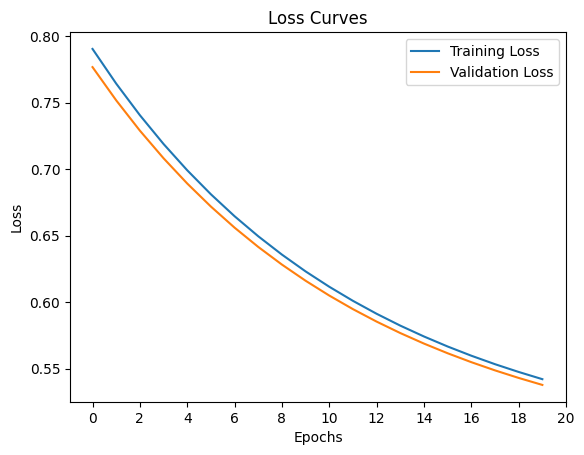

In [6]:
train_losses = model.train_losses
eval_losses = model.eval_losses
epochs = model.epochs

plt.plot(range(0, epochs), train_losses, label="Training Loss")
plt.plot(range(0, epochs), eval_losses, label="Validation Loss")
plt.xticks(ticks=np.arange(0, epochs + 1, 2))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [7]:
model.save('models/test-model.pt')

In [8]:
from evaluation import Evaluation

evaluator = Evaluation(recommender=model, test_data=df_test, k=10)
evaluator.evaluate()

Processing user batch 1/149008
Processing user batch 1025/149008
Processing user batch 2049/149008
Processing user batch 3073/149008
Processing user batch 4097/149008
Processing user batch 5121/149008
Processing user batch 6145/149008
Processing user batch 7169/149008
Processing user batch 8193/149008
Processing user batch 9217/149008
Processing user batch 10241/149008
Processing user batch 11265/149008
Processing user batch 12289/149008
Processing user batch 13313/149008
Processing user batch 14337/149008
Processing user batch 15361/149008
Processing user batch 16385/149008
Processing user batch 17409/149008
Processing user batch 18433/149008
Processing user batch 19457/149008
Processing user batch 20481/149008
Processing user batch 21505/149008
Processing user batch 22529/149008
Processing user batch 23553/149008
Processing user batch 24577/149008
Processing user batch 25601/149008
Processing user batch 26625/149008
Processing user batch 27649/149008
Processing user batch 28673/14900

{'Hit Ratio@10': 0.0004697734349833566,
 'NDCG@10': 0.00021063614434372878,
 'Recall@10': 0.0004190810464634689}